In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))

# Define transformations for the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Add random rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jittering
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 dataset
batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)



Using device: cuda
Current GPU: NVIDIA A40
Files already downloaded and verified
Files already downloaded and verified


In [2]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(IntermediateBlock, self).__init__()
        self.num_conv_layers = num_conv_layers

        # Create L independent convolutional layers with batch normalization
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                # First layer takes in_channels, subsequent take out_channels
                nn.Conv2d(in_channels if i == 0 else out_channels,
                         out_channels,
                         kernel_size=3,
                         padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            for i in range(num_conv_layers)
        ])

        # Activation function
        self.relu = nn.ReLU(inplace=True)

        # Fully connected layer to compute weights vector a
        self.fc = nn.Linear(in_channels, num_conv_layers) 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size = x.size(0)

        # Calculate the average value of each channel
        m = torch.mean(x, dim=(2, 3))

        # Compute weights vector a using fully connected layer
        a = self.fc(m)  # Shape: [batch_size, num_conv_layers]
        a = self.softmax(a)

        # Apply each convolutional layer sequentially
        conv_outputs = []
        current = x
        for i in range(self.num_conv_layers):
            current = self.conv_layers[i](current)
            conv_outputs.append(current)

        # Combine outputs using weights
        x_prime = torch.zeros_like(conv_outputs[0])
        for i in range(self.num_conv_layers):
            weight = a[:, i].view(batch_size, 1, 1, 1)
            x_prime += weight * conv_outputs[i]

        return x_prime

In [3]:
class CIFAR10Network(nn.Module):
    def __init__(self):
        super(CIFAR10Network, self).__init__()

        # Define the intermediate blocks
        self.block1 = IntermediateBlock(in_channels=3, out_channels=64, num_conv_layers=4)
        self.block2 = IntermediateBlock(in_channels=64, out_channels=128, num_conv_layers=5)
        self.block3 = IntermediateBlock(in_channels=128, out_channels=256, num_conv_layers=6)

        # Pooling layers between blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Output block
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Intermediate blocks
        x = self.block1(x)
        x = self.bn1(x)
        x = self.pool(x)

        x = self.block2(x)
        x = self.bn2(x)
        x = self.pool(x)

        x = self.block3(x)
        x = self.bn3(x)
        x = self.pool(x)

        # Output block
        # Calculate the average value of each channel
        m = torch.mean(x, dim=(2, 3))  

        # Fully connected layers
        m = self.relu(self.fc1(m))
        m = self.dropout(m)
        logits = self.fc2(m)

        return logits


In [4]:
def train(model, trainloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if i % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss/100:.3f}, Acc: {100.*correct/total:.3f}%')
            batch_losses.append(running_loss/100)
            running_loss = 0.0

    return 100.*correct/total

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100.*correct/total
    print(f'Test Accuracy: {accuracy:.3f}%')
    return accuracy


Epoch: 1, Batch: 100, Loss: 1.926, Acc: 27.641%
Epoch: 1, Batch: 200, Loss: 1.702, Acc: 31.414%
Epoch: 1, Batch: 300, Loss: 1.540, Acc: 35.292%
Epoch: 1, Batch: 400, Loss: 1.413, Acc: 38.535%
Epoch: 1, Batch: 500, Loss: 1.307, Acc: 41.422%
Epoch: 1, Batch: 600, Loss: 1.238, Acc: 43.688%
Epoch: 1, Batch: 700, Loss: 1.238, Acc: 45.475%
Test Accuracy: 59.590%
Epoch 1/50, Train Acc: 46.616%, Test Acc: 59.590%
Epoch: 2, Batch: 100, Loss: 1.131, Acc: 58.703%
Epoch: 2, Batch: 200, Loss: 1.123, Acc: 59.234%
Epoch: 2, Batch: 300, Loss: 1.096, Acc: 59.547%
Epoch: 2, Batch: 400, Loss: 1.049, Acc: 60.352%
Epoch: 2, Batch: 500, Loss: 1.013, Acc: 61.097%
Epoch: 2, Batch: 600, Loss: 0.978, Acc: 61.766%
Epoch: 2, Batch: 700, Loss: 0.993, Acc: 62.208%
Test Accuracy: 64.600%
Epoch 2/50, Train Acc: 62.544%, Test Acc: 64.600%
Epoch: 3, Batch: 100, Loss: 0.900, Acc: 67.750%
Epoch: 3, Batch: 200, Loss: 0.909, Acc: 67.875%
Epoch: 3, Batch: 300, Loss: 0.900, Acc: 67.786%
Epoch: 3, Batch: 400, Loss: 0.872, Acc

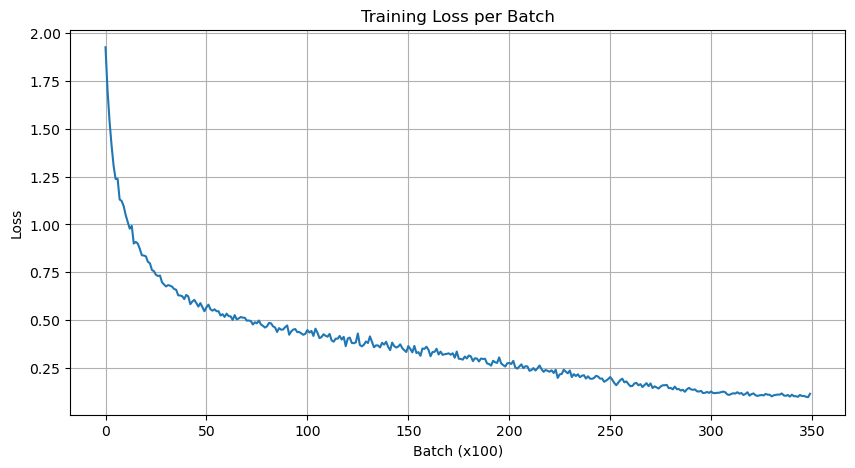

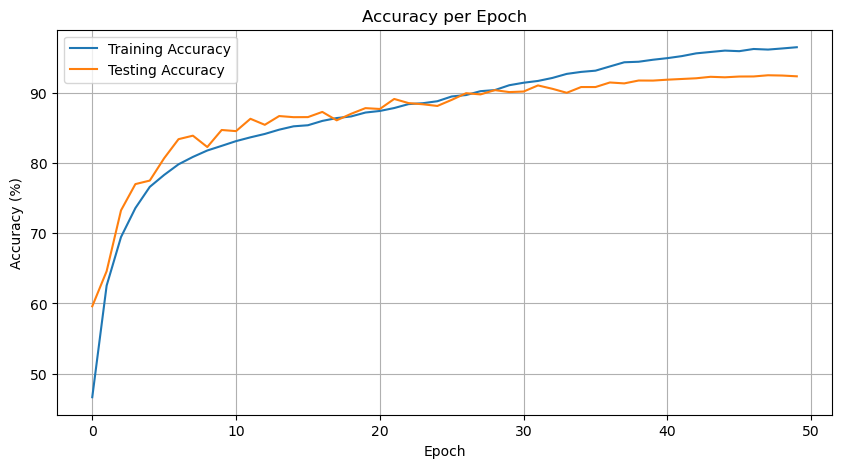

Highest Test Accuracy: 92.560%


In [7]:
# Initialize model and move to device
model = CIFAR10Network().to(device)
num_epochs = 50
# Loss function and optimizer with potentially adjusted hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=4e-4) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  


# Lists to store metrics
batch_losses = []
train_accuracies = []
test_accuracies = []

# Number of epochs
num_epochs = 50

# Train the model
for epoch in range(num_epochs):
    train_acc = train(model, trainloader, criterion, optimizer, epoch)
    test_acc = test(model, testloader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Adjust learning rate
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.3f}%, Test Acc: {test_acc:.3f}%')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(batch_losses)
plt.title('Training Loss per Batch')
plt.xlabel('Batch (x100)')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# Plot training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy.png')
plt.show()

# Print the highest test accuracy
highest_acc = max(test_accuracies)
print(f'Highest Test Accuracy: {highest_acc:.3f}%')
